# **Topology Optimization of a Membrane and Report Generation with $\LaTeX$**

In [1]:
import sympy as sy
from sympy import symbols, Function, diff, Matrix, MatMul, \
    integrate, Symbol, sin, cos, pi, simplify
import pylatex as pltx
from pylatex import Section, Subsection, Command, NoEscape, Package, NewPage, Tabular
from sigmaepsilon.solid.fourier.latex import expr_to_ltx, expr_to_ltx_breqn
from sigmaepsilon.solid.fourier.symtools import inv_sym_3x3


In [2]:
geometry_options = {
    "tmargin": "1.5cm",
    "lmargin": "1.5cm",
    "rmargin": "1.5cm"
}

doc = pltx.Document(geometry_options=geometry_options)

r"""
Tools related to displaying math. It's a bit like the numpy of latex, must
have stuff.
"""
doc.packages.append(Package('amsmath'))

r"""
Sympy uses the 'operatorname' command frequently to print symbols.
"""
doc.packages.append(Package('amsopn'))

r"""
To automatically break long equations into multiple lines.
"""
doc.packages.append(Package('breqn'))

# to insert pgf files
doc.packages.append(Package('pgf'))
doc.packages.append(Package('pgfplots'))
doc.packages.append(Package('pdfpages'))
#doc.packages.append(NoEscape("\usetikzlibrary{arrows.meta}"))

r"""
mathtools provides us with the \coloneqq command, for defining equality
symbol ':='
"""
doc.packages.append(Package('mathtools'))

r"""
Misc
"""
doc.packages.append(Package('enumitem'))  # to customize enumerations
doc.packages.append(Package('xcolor'))  # colors
doc.packages.append(Package('lmodern'))  # high quality fonts

title = "Topology Optimization with the Optimality Criteria Method"
doc.preamble.append(Command('title', title))
doc.preamble.append(Command('author', 'Bence Balogh'))
doc.preamble.append(Command('date', NoEscape(r'\today')))
doc.append(NoEscape(r'\maketitle'))
doc.append(NoEscape(r'\tableofcontents'))
doc.append(NewPage())

sections = {}


## **Step 1 : Define a Mesh**

In [3]:
from polymesh.grid import gridQ9
import numpy as np

size = Lx, Ly = (15, 10)
shape = nx, ny = (45, 30)

gridparams = {
    'size': size,
    'shape': shape,
    'origo': (0, 0),
    'start': 0
}

coords_, topo = gridQ9(**gridparams)
coords = np.zeros((coords_.shape[0], 3))
coords[:, :2] = coords_[:, :]


## **Step 2 : Define a Material**

In [4]:
E = 12000
nu = 0.2
t = 0.25
A = np.array([[1, nu, 0], [nu, 1, 0], [0., 0, (1-nu)/2]]) * (t * E / (1-nu**2))


In [5]:
sections['Input'] = doc.create(Section('Input'))

with sections['Input']:
     with doc.create(Tabular('l|l')) as table:
        #table.add_hline()
        table.add_row(('Shape', (Lx, Ly)))
        table.add_row(('Size', (nx, ny)))
        table.add_row(('Thickness', t))
        table.add_row(("Young's modulus", E))
        table.add_row(("Poisson's ratio", nu))

## **Step 3 : Set Boundary Conditions**

In [6]:
from polymesh.space.utils import index_of_closest_point
# fix points at x==0
#cond = (coordsQ4[:, 0] <= 0.001) & (coordsQ4[:, 1] >= (Ly/2))
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 6), dtype=bool)
fixity[ebcinds, :] = True
#fixity[:, 2:] = True

# unit vertical load on points at (Lx, Ly)
Fz = -100.0
loads = np.zeros((coords.shape[0], 6))
loadindex = index_of_closest_point(coords, np.array([2*Lx/3, Ly/2, 0]))
loads[loadindex, 1] = Fz


## **Step 4 : Assembly and Solution**

In [7]:
from polymesh.space import StandardFrame
from sigmaepsilon.solid.fem.mesh import FemMesh
from sigmaepsilon.solid.fem.structure import Structure
from sigmaepsilon.solid.fem.cells import Q9M as Q9
from sigmaepsilon.solid import PointData

GlobalFrame = StandardFrame(dim=3)
pd = PointData(coords=coords, frame=GlobalFrame, loads=loads, fixity=fixity)
cd = Q9(topo=topo, frame=GlobalFrame)
meshQ4 = FemMesh(pd, cd, model=A, frame=GlobalFrame)
structure = Structure(mesh=meshQ4)

structure.linsolve(summary=True)
dofsol = structure.nodal_dof_solution()
structure.mesh.pointdata['x'] = coords + dofsol[:, :3]


## **Step 5 : Triangulate and Plot**

In [8]:
%matplotlib inline


In [9]:
from polymesh.topo.tr import Q4_to_T3
from polymesh.tri.trimesh import triangulate
from polymesh.tri.triplot import triplot
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
plt.style.use("classic")  # dark_background

points, triangles = Q4_to_T3(structure.mesh.coords(), topo)
triobj = triangulate(points=points[:, :2], triangles=triangles)[-1]


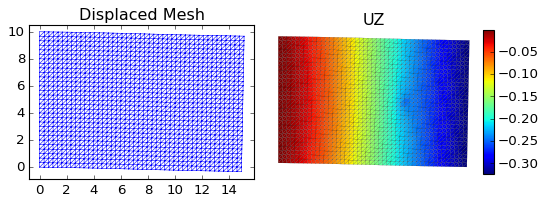

In [10]:
fig = plt.figure(figsize=(7, 4))  # in inches
fig.patch.set_facecolor('white')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
triplot(triobj, ax=ax1, fig=fig)
triplot(triobj, ax=ax2, fig=fig, data=dofsol[:, 1], cmap='jet', axis='off')
fig.tight_layout()
ax1.set_title('Displaced Mesh')
ax2.set_title('UZ')
#fig.suptitle('Finite Element Solution')
fig.tight_layout()
plt.savefig("simp_oc_membrane.pdf")

In [11]:
sections['Output'] = doc.create(Section('Output'))

with sections['Output']:
    doc.append(NoEscape(
        r"""
        \begin{figure}[htp] \centering{
        \includegraphics[scale=1.0]{simp_oc_membrane.pdf}}
        \caption{Experiment 1}
        \end{figure}  
        """))
    

## **Step 6 : Optimize**

In [12]:
%matplotlib inline
plt.style.use('classic')


In [13]:
OC_params = {
    'p_start': 1.0,  # SIMP penalty factor
    'p_stop': 3.0,
    'p_inc': 0.1,
    'p_step': 5,
    'q': 0.5,  # smoothing factor
    'vfrac': 0.5,  # fraction of target volume over initial volume
    'dtol': 0.1,  # to control maximum change in the variables
    'r_min': 2 * max(Lx/nx, Ly/ny),  # for the density filter
    'miniter': 30,
    'maxiter': 100
}


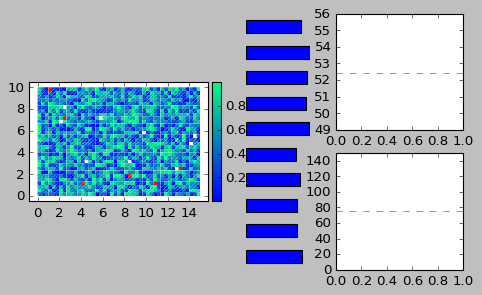

In [14]:
from neumann import histogram
from matplotlib import gridspec
import matplotlib as mpl
from IPython.display import display, clear_output

fig = plt.figure(figsize=(7, 4))  # in inches
# fig.patch.set_facecolor('white')
gs = gridspec.GridSpec(2, 3, width_ratios=[6, 2, 4])

uz = structure.mesh.pointdata.dofsol[loadindex, 1].min()
nCell = structure.mesh.number_of_cells()
history = {'comp': [], 'vol': [], 'x': []}
history['comp'].append(2*uz*Fz)
history['x'].append(np.random.rand(nCell))
history['vol'].append(Lx*Ly)

nbins = 10
hist, bin_centers = histogram(history['x'][-1], nbins)
hist = hist.astype(float)
hist /= hist.max()
ax1 = fig.add_subplot(gs[:, 1])
ax1.set_facecolor('white')
bars = ax1.barh(bin_centers, hist, 0.5/nbins)
ax1.set_xlim(0, 1)
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 2])
ax2.axhline(y=history['comp'][-1], color="r", linestyle="--", lw=0.5)
#ax2.set_ylim(0, history['comp'][-1]*1.2)

ax3 = fig.add_subplot(gs[1, 2])
ax3.set_ylim(0, history['vol'][-1])
ax3.axhline(y=history['vol'][-1]*OC_params['vfrac'],
            color="r", linestyle="--", lw=0.5)

cmap = plt.cm.winter  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
#cmaplist[0] = (.5, .5, .5, 1.0)
#cmaplist[-1] = (1., 0., 0., 1.0)
# cmaplist.reverse()
cmaplist[0] = (1., 1., 1., 1.0)
cmaplist[-1] = (1., 0., 0., 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 10, 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

ax4 = fig.add_subplot(gs[:, 0])
points, triangles, edata = \
    Q4_to_T3(coords, topo, data=history['x'][-1])
triobj = triangulate(points=points[:, :2], triangles=triangles)[-1]
trifield = triplot(triobj, ax=ax4, data=edata, axis='on',
                   lw=0.0, fig=fig, cmap=cmap)[0]

def callback_qt(i, comp, vol, dens):
    history['comp'].append(comp)
    history['vol'].append(vol)
    history['x'].append(dens)
    fig.canvas.manager.window.raise_()
    hist, _ = histogram(dens, nbins)
    hist = hist.astype(float)
    hist /= hist.max()
    for bar, h in zip(bars, hist):
        bar.set_width(h)
    ax2.plot(i, comp, marker='o', c='b', markersize='1')
    ax3.plot(i, vol, marker='*', c='g', markersize='1')
    ax2.set_xlim(0, i+1)
    ax3.set_xlim(0, i+1)
    *_, edata = Q4_to_T3(coords, topo, data=dens)
    trifield.set_array(edata)
    fig.canvas.draw()
    fig.canvas.flush_events()


def callback_inline(i, comp, vol, dens):
    history['comp'].append(comp)
    history['vol'].append(vol)
    history['x'].append(dens)
    hist, _ = histogram(dens, nbins)
    hist = hist.astype(float)
    hist /= hist.max()

    ax1.cla()
    ax1.barh(bin_centers, hist, 0.5/nbins)
    ax2.plot(i, comp, marker='o', c='b', markersize='1')
    ax3.plot(i, vol, marker='*', c='g', markersize='1')
    ax4.cla()
    *_, edata = Q4_to_T3(coords, topo, data=dens)
    triplot(triobj, ax=ax4, data=edata, axis='off', lw=0.0,
            fig=fig, cmap=cmap)[0]

    display(fig)
    clear_output(wait=True)
    plt.pause(0.1)
plt.savefig("simp_oc_membrane_opt.pdf")

In [15]:
structure.summary['linsolve', 'proc', 'time']


0.30699872970581055

In [16]:
from sigmaepsilon.topopt.oc.SIMP_OC_FEM import OC_SIMP_COMP as OC
neighbours = structure.mesh.k_nearest_cell_neighbours(7)


In [17]:
# iteration parameters
OC_params = {
    'p_start': 1.0,  # SIMP penalty factor
    'p_stop': 2.5,
    'p_inc': 0.1,
    'p_step': 10,
    'q': 0.5,  # smoothing factor
    'vfrac': 0.25,  # fraction of target volume over initial volume
    'dtol': 0.1,  # to control maximum change in the variables
    'r_max': 3 * max(Lx/nx, Ly/ny),  # for the density filter
    'miniter': 30,
    'maxiter': 1e12,
    'neighbours': neighbours
}
optimizer = OC(structure, summary=True, **OC_params)
next(optimizer)
ax2.set_xlim(0, len(history['comp']))
ax3.set_xlim(0, len(history['comp']))


(0.0, 1.0)

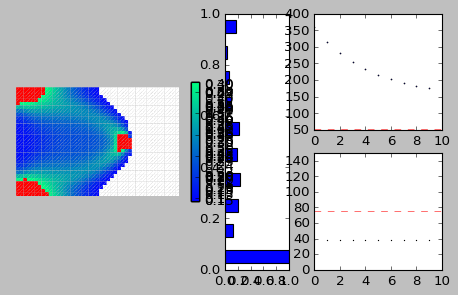

In [18]:
for i in range(10):
    r = next(optimizer)
    callback_inline(r.n, r.obj, r.vol, r.x)
    ax2.set_xlim(0, len(history['comp']))
    ax3.set_xlim(0, len(history['comp']))

In [19]:
sections['Topopt'] = doc.create(Section('Topopt'))

with sections['Topopt']:
    doc.append(NoEscape(
        r"""
        \begin{figure}[htp] \centering{
        \includegraphics[scale=1.0]{simp_oc_membrane_opt.pdf}}
        \caption{Experiment 2}
        \end{figure}  
        """))

In [20]:
doc.generate_pdf('tesseract_oc_sym', clean_tex=False, compiler='pdfLaTeX')

In [21]:
raise

RuntimeError: No active exception to reraise

# Plotly Dashboard

In [ ]:
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import dcc
import dash_bootstrap_components as dbc
from dash import html
from dash.dependencies import Input, Output

input_groups = html.Div(
    [

        dbc.InputGroup(
            [
                dbc.InputGroupText("Width"),
                dbc.Input(placeholder="width of the membrane", type="number"),
                dbc.InputGroupText("[cm]"),
            ],
            className="mb-3",
        ),
        dbc.InputGroup(
            [
                dbc.InputGroupText("Height"),
                dbc.Input(placeholder="height of the membrane", type="number"),
                dbc.InputGroupText("[cm]"),
            ],
            className="mb-3",
        ),
        dbc.InputGroup(
            [
                dbc.InputGroupText("Thickness"),
                dbc.Input(placeholder="thickness of the membrane",
                          type="number"),
                dbc.InputGroupText("[cm]"),
            ],
            className="mb-3",
        ),
        dbc.InputGroup(
            [
                dbc.InputGroupText("Young's modulus"),
                dbc.Input(placeholder="", type="number"),
                dbc.InputGroupText("[MPa]"),
            ],
            className="mb-3",
        ),
        dbc.InputGroup(
            [
                dbc.InputGroupText("Poisson's ratio"),
                dbc.Input(placeholder="", type="number"),
                dbc.InputGroupText("[-]"),
            ],
            className="mb-3",
        ),

    ]
)

button = html.Div(
    [
        dbc.Button(
            "Click me", id="example-button", className="me-2", n_clicks=0
        ),
        html.Span(id="example-output", style={"verticalAlign": "middle"}),
    ]
)

# Build App
app = JupyterDash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = html.Div([input_groups, button])


@app.callback(
    Output("example-output", "children"),
    [Input("example-button", "n_clicks")]
)
def on_button_click(n):
    if n is None:
        return "Not clicked."
    else:
        return f"Clicked {n} times."


# Run app and display result inline in the notebook
app.run_server(mode='external', port='8892')
